In [1]:
import pylab as plt
import numpy as np
import time as tm 

In [2]:

#Harmonic force and internal energy
def energy_force(x, t, v0, ks):
    F = -ks*(x - v0*t)
    dF = ks*v0
    return F, dF

# asymmetrical normal distribution
def d_random_normal(a,b):
    np.seed(42)
    x = np.sqrt(np.random.uniform(a,b))*np.random.normal(a,b)
    return x

# part A update
def position_update(x, v, dt):
    x_new = x + v*dt/2.
    return x_new

# part B update
def velocity_update(v, a, F, dF, dt):
    v_new = v + F*dt/2.
    a_new = a + dF*dt/2.
    return v_new, a_new

# part O update
def random_velocity_update(v, a, dt, mu, lamb, gamma, KbT):    
    c_v1 = + np.exp(-gamma*dt)
    c_v2 = + np.sqrt(1-np.exp(-2*gamma*dt))
    #c_v3 = + np.sqrt(1-np.exp(-3*gamma*dt))
    c_a1 = - gamma * np.exp(-gamma*dt)
    c_a2 = + gamma * np.exp(-2*gamma*dt)/np.sqrt(1 - np.exp(-2*gamma*dt))
    #c_a3 = + 3/2 * gamma * np.exp(-3*gamma*dt)/np.sqrt(1 - np.exp(-3*gamma*dt))
    
    Rg = np.sqrt(KbT) * np.random.normal(0,1)
    Rp = np.sqrt(mu*lamb/(2*gamma)) * np.random.normal(0,1) * np.random.poisson(1)

    rayleigh_d = np.square(1) * np.random.rayleigh(1)
    Rp_v = np.sqrt(np.abs(v) * mu) * rayleigh_d * np.random.poisson(1)  

    v_new = c_v1*v + c_v2*(Rg + Rp) #+ c_v3*(Rp_v)
    a_new = c_a1*a + c_a2*(Rg + Rp) #+ c_a3*(Rp_v)
    return v_new, a_new

In [3]:
def BAOAB_method(*args):
    mu, lamb = args[0], args[1]
    x_init, v_init = args[2], args[3]
    v0, ks, gamma, kBT = args[4], args[5], args[6], args[7]
    tMax, dt = args[8], args[9]
    x = x_init
    v = v_init
    a = 0
    t = 0
    time, d_s0, d_s1 = [], [], []
    
    while(t<tMax):
        ##################
        # part B
        F, dF = energy_force(x, t, v0, ks)
        v, a = velocity_update(v, a, F, dF, dt)
        
        # part A
        x = position_update(x, v, dt)
        
        # part O
        v, a = random_velocity_update(v, a, dt, mu, lamb, gamma, kBT)
        
        # part A
        x = position_update(x, v, dt)
    
        # part B
        F, dF = energy_force(x, t, v0, ks)
        v, a = velocity_update(v, a, F, dF, dt)
        ##################
    
        # S per trajectory calculation
        F, dF = energy_force(x, t, v0, ks)
        ds0 = v0*F/kBT 
        ds1 = mu * a * (v * (-3*kBT + v**2)/(4*kBT**3))

        time.append(t)
        d_s0.append(ds0)
        d_s1.append(ds1)

        t += dt
        if t >= tMax//2:
            v0 = 0

    return time, d_s0, d_s1

In [4]:
# Parameters and time
v0 = 0.2
ks = 1.0
gamma = 1.0
KbT = 5.

dt = 0.01
tMax = 350 

mu = 0.01
lamb = gamma

# Sample conditions
N = 10**4
x_init = 0.3
v_init = 0.

# Work vector definition and extras
gauss_sF = np.zeros(N)
sF0, sF1 = np.zeros(N), np.zeros(N)

In [5]:
###################### MAIN #############################
start = tm.time()

########### Gaussian EP ###########
# Stochastic evolution and work for each trajectory in a sample
param_F = tuple([0.0, 0.0, x_init, v_init, v0, ks, gamma, KbT, tMax, dt])

#for ii in range(N): 
    #t_F, ds_F, _, = BAOAB_method(*param_F)
    #gauss_sF[ii] = np.trapz(ds_F, t_F)

########### NG EP ###########
# Stochastic evolution and work for each trajectory in a sample
nG_param_F = tuple([mu, lamb, x_init, v_init, v0, ks, gamma, KbT, tMax, dt])

for ii in range(N): 
    t_sF, ds0_F, ds1_F = BAOAB_method(*nG_param_F)
    sF0[ii] = np.trapezoid(ds0_F, t_sF)
    sF1[ii] = np.trapezoid(ds1_F, t_sF)

end = tm.time()
print((end-start)/60)
#########################################################

63.7253474632899


In [6]:
# An. coeficients 
nG_sF0 = sF0
nG_sF1 =  sF1 

print(np.mean(nG_sF0), np.var(nG_sF0))
print(np.mean(nG_sF1), np.var(nG_sF1))

# Statistics
Y = nG_sF0 - nG_sF1
mean_v = np.mean(Y)
quant2 = np.abs(Y - mean_v)**2
var_v = np.sum(quant2)/N
kur_v = np.sum((quant2)**2)/N/var_v**2

print();print(mean_v)
print(var_v)
print(kur_v)

1.3894799180831572 2.7772436822179243
0.08820381848018002 0.018089997319863486

1.301276099602977
2.794848441664138
3.054949173840798


In [7]:
from scipy.optimize import leastsq
fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2 + p[3]) + p[4]
errfunc  = lambda p, x, y: (y - fitfunc(p, x))
init  = [1.0, 0.5, 0.5, 0.8, 0.5]

0.2558711588968583

131.26596933921277 0.5169082545063722 0.5349944988927736 -130.41185758970104 0.10775862057594204
350


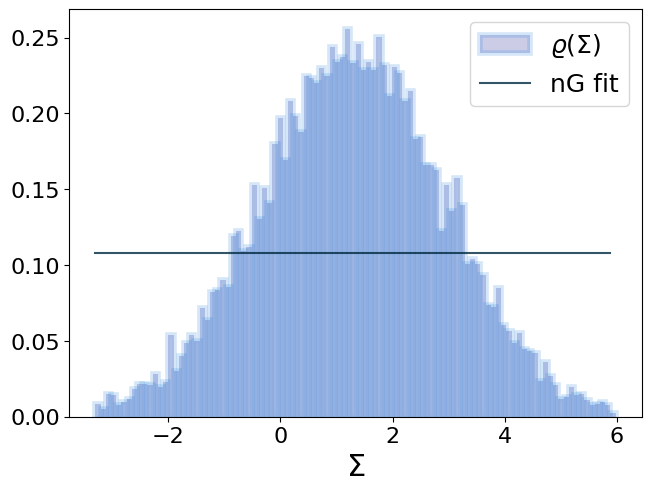

In [8]:
plt.rcParams.update({'font.size': 16})
n_bins = 100
#range_hist = (-1.3,1.9)
range_hist = (-3.3,5.98)

########## Work Histogram and Analitical curve ##########
plt.figure(constrained_layout=True)

nF, binsF, _ = plt.hist(
    Y,
    color = 'darkblue', 
    range =  range_hist,
    histtype='bar', 
    linewidth=4, 
    alpha= 0.2, 
    ec=(0.165, 0.52, 0.87),
    bins= n_bins, 
    density=True,  
    label = r'$\varrho(\mathsf{\Sigma})$'
    )

print(np.max(nF))

out_F = leastsq(errfunc, init, args=(binsF[:-1], nF))
fit_F = fitfunc(out_F[0], binsF[:-1])
c_F = out_F[0]
print();print(c_F[0], c_F[1], c_F[2], c_F[3], c_F[4])

plt.plot(binsF[:-1], fit_F, color = (0/255, 42/255, 64/255), alpha= 0.8, label = 'nG fit')

plt.xlabel(r'$\mathsf{\Sigma}$', fontsize = 22, labelpad = 4)
plt.legend(loc='upper right', fontsize = 18)
plt.savefig('/Users/fariaart/Downloads/dist_%s.pdf' %mu, transparent=False)
print(tMax)

In [9]:
print(binsF[1],binsF[0])
bin_width = binsF[1] - binsF[0]
# sum over number in each bin and mult by bin width, which can be factored out
integral = bin_width * sum(fit_F)
integral

-3.2072 -3.3


np.float64(0.9999999989447411)

In [13]:
fun = np.exp(-binsF[:-1])*nF
intg = np.trapezoid(fun, binsF[:-1])
print(intg)

0.9978176968621718


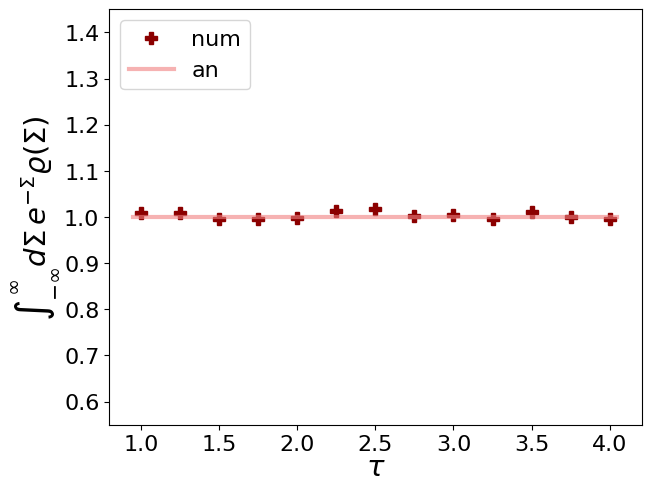

In [11]:
vec = [1.0082617038027362, #100
       1.009024096913803, #125
       0.9967196003495216, #150
       0.9967196003495216, #175
       0.9986321650594288, #200
       1.0125571634389445, #225
       1.016352902137633, #250
       1.003207976751417, #275
       1.0044379852783867, #300
       0.9963204891485704, #325
       1.011100490686736, #350
       0.9991571330128786, #375
       0.9967056907237644] #400

tau = [1.0, 1.25, 1.5, 1.75, 2., 2.25, 2.5, 2.75, 3., 3.25, 3.5, 3.75, 4.]

def const(x):
    return np.full(x.shape, 1)

plt.rcParams.update({'font.size': 16})
t1 = np.linspace(0.95,4.05,100)
plt.figure(constrained_layout=True)
plt.ylim(0.55,1.45)
plt.plot(tau, vec, 'P', color = "darkred", markersize= 8.0, label = 'num',)
plt.plot(t1, const(t1), color = 'lightcoral', linewidth= 3, alpha = 0.6, label = 'an' )
plt.xlabel(r'$\tau$', fontsize = 21, labelpad = -1)
plt.ylabel(r'$\int_{-\infty}^{\infty} d\mathsf{\Sigma}\, e^{-\mathsf{\Sigma}}\varrho(\mathsf{\Sigma})$', fontsize = 21, labelpad = 2)
plt.legend(loc='upper left', fontsize = 16)
plt.savefig('/Users/fariaart/Downloads/Jarzy-FT_%s.pdf' %mu, transparent=False)
plt.show()